# Homework 2: Discovery of Frequent Itemsets and Association Rules

This notebook:
1. loads the dataset `data/T10I4D100K.dat` (expected as transactions of item ids),
2. implements A-Priori (candidate generation, pruning, counting),
3. finds frequent itemsets with support ≥ `min_support` (absolute count),
4. prints summary stats and saves results to `frequent_itemsets.csv`.

In [1]:
import os
from collections import defaultdict
from itertools import combinations
from time import time

DATA_PATH = "data/T10I4D100K.dat" 
OUTPUT_CSV = "frequent_itemsets.csv"

min_support = 1000

## Load transactions
Read the transaction file robustly: each line is a transaction with item ids. The loader tolerates various separators.
It returns a list of frozensets (one per transaction), plus counts (n_transactions).

In [2]:
def load_transactions(path):
    """
    Load transactions from file path. Each line becomes a transaction.
    Items are parsed as tokens of digits (ints). Returns list of frozensets.
    """
    transactions = []
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} not found.")
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # split non-digit characters; keep tokens that are digits
            # this also handles commas/braces if present
            tokens = []
            cur = ""
            for ch in line:
                if ch.isdigit():
                    cur += ch
                else:
                    if cur:
                        tokens.append(cur)
                        cur = ""
            if cur:
                tokens.append(cur)
            # convert to ints
            try:
                items = frozenset(int(t) for t in tokens) if tokens else frozenset()
            except ValueError:
                # fallback: split on whitespace
                parts = [p for p in line.split() if p.strip()]
                items = frozenset(int(p) for p in parts)
            if items:
                transactions.append(items)
    return transactions

# Load and basic stats
t0 = time()
transactions = load_transactions(DATA_PATH)
n_transactions = len(transactions)
t1 = time()
print(f"Loaded {n_transactions} transactions in {t1-t0:.2f}s")

Loaded 100000 transactions in 0.35s


## Apriori implementation
We implement:
- `get_frequent_1_itemsets(transactions, min_support)` — count singletons.
- `apriori_gen(Lk_minus_1, k)` — candidate generation (join + prune by subsets).
- `count_supports(candidates, transactions)` — support counting.
- `apriori(transactions, min_support)` — main loop returning dictionary {k: {itemset: support}}.
This implementation stores itemsets as tuples with items in sorted order for determinism.

In [3]:
def get_frequent_1_itemsets(transactions, min_support):
    counts = defaultdict(int)
    for t in transactions:
        for item in t:
            counts[item] += 1
    L1 = {}
    for item, cnt in counts.items():
        if cnt >= min_support:
            L1[(item,)] = cnt
    return L1

def apriori_gen(Lk_minus_1, k):
    """
    Lk_minus_1: dict of (k-1)-itemset tuples -> support
    k: target size for candidates
    Returns: set of candidate k-itemset tuples (sorted)
    """
    prev_itemsets = sorted(Lk_minus_1.keys())
    candidates = set()
    len_prev = len(prev_itemsets)
    for i in range(len_prev):
        for j in range(i+1, len_prev):
            a = prev_itemsets[i]
            b = prev_itemsets[j]
            # join if first k-2 items equal
            if a[:k-2] == b[:k-2]:
                new_candidate = tuple(sorted(set(a) | set(b)))
                if len(new_candidate) == k:
                    # prune: all (k-1)-subsets must be in Lk_minus_1
                    subsets_ok = True
                    for subset in combinations(new_candidate, k-1):
                        if tuple(subset) not in Lk_minus_1:
                            subsets_ok = False
                            break
                    if subsets_ok:
                        candidates.add(new_candidate)
            else:
                break  # lexicographic order optimization
    return candidates

def count_supports(candidates, transactions):
    """
    candidates: iterable of itemset tuples
    returns dict itemset->support
    """
    counts = defaultdict(int)
    candidate_list = list(candidates)
    # for faster lookup convert candidates to set of frozensets
    cand_sets = [frozenset(c) for c in candidate_list]
    for t in transactions:
        # for each candidate, test subset; optimization possible by building subsets of t
        for idx, cset in enumerate(cand_sets):
            if cset.issubset(t):
                counts[candidate_list[idx]] += 1
    return dict(counts)

def apriori(transactions, min_support, max_k=None):
    """
    Run Apriori, return dict: k -> dict(itemset_tuple -> support)
    max_k: optional maximum size of itemsets to produce
    """
    frequent_itemsets = dict()
    # L1
    L1 = get_frequent_1_itemsets(transactions, min_support)
    k = 1
    Lk = L1
    if Lk:
        frequent_itemsets[k] = Lk
    while Lk:
        k += 1
        if max_k and k > max_k:
            break
        candidates = apriori_gen(Lk, k)
        if not candidates:
            break
        counts = count_supports(candidates, transactions)
        # keep those meeting min_support
        Lk = {c: cnt for c, cnt in counts.items() if cnt >= min_support}
        if Lk:
            frequent_itemsets[k] = Lk
    return frequent_itemsets

## Run Apriori and show results
This cell runs the algorithm with chosen `min_support` and prints:
- time taken
- count of frequent itemsets per size k
- top frequent singletons
It also writes results to `frequent_itemsets.csv`.

In [4]:
t0 = time()
freq_itemsets = apriori(transactions, min_support, max_k = 3)
t1 = time()
print(f"Apriori finished in {t1-t0:.2f}s")

# summary
total_found = sum(len(d) for d in freq_itemsets.values())
print(f"Total frequent itemsets found: {total_found}")
for k in sorted(freq_itemsets):
    print(f" k={k}: {len(freq_itemsets[k])} itemsets")

# top frequent singletons
if 1 in freq_itemsets:
    top_singletons = sorted(freq_itemsets[1].items(), key=lambda x: -x[1])[:10]
    print("\nTop frequent singletons (item,), support:")
    for it, sup in top_singletons:
        print(it, sup)
else:
    print("No frequent singletons at this support.")

# Export all frequent itemsets to CSV: columns (k, itemset, support)
import csv
with open(OUTPUT_CSV, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["k", "itemset", "support"])
    for k in sorted(freq_itemsets):
        for itemset, sup in sorted(freq_itemsets[k].items(), key=lambda x:(len(x[0]), -x[1]) if isinstance(x[0], tuple) else (k, -x[1])):
            writer.writerow([k, " ".join(map(str,itemset)), sup])

print(f"\nWritten frequent itemsets to {OUTPUT_CSV}")

Apriori finished in 391.47s
Total frequent itemsets found: 385
 k=1: 375 itemsets
 k=2: 9 itemsets
 k=3: 1 itemsets

Top frequent singletons (item,), support:
(368,) 7828
(529,) 7057
(829,) 6810
(766,) 6265
(722,) 5845
(354,) 5835
(684,) 5408
(217,) 5375
(494,) 5102
(419,) 5057

Written frequent itemsets to frequent_itemsets.csv


If we vary the support threshold we can verify how it affects the execution time and the number of frequent itemsets found.

In [8]:
# Define the support thresholds to test
supports = [500, 750, 1000, 1250, 1500] 

durations = []
n_freq_items = []

print(f"Starting benchmark on {len(supports)} thresholds...")

# Loop through thresholds
for s in supports:
    print(f"Running Apriori with min_support={s}...", end=" ")
    
    t0 = time()
    curr_freq_itemsets = apriori(transactions, min_support=s, max_k=3)
    t1 = time()
    
    duration = t1 - t0
    durations.append(duration)
    
    total_found = sum(len(d) for d in curr_freq_itemsets.values())
    n_freq_items.append(total_found)
    
    print(f"Done in {duration:.2f}s (Found {total_found} itemsets)")

Starting benchmark on 5 thresholds...
Running Apriori with min_support=500... Done in 872.48s (Found 1021 itemsets)
Running Apriori with min_support=750... Done in 583.50s (Found 556 itemsets)
Running Apriori with min_support=1000... Done in 383.26s (Found 385 itemsets)
Running Apriori with min_support=1250... Done in 258.25s (Found 310 itemsets)
Running Apriori with min_support=1500... Done in 151.79s (Found 237 itemsets)


We observe that even though the size of the dataset is the same, the execution time decreases with the increase in the support threshold given that more candidates are generated and more itemsets have to be checked.

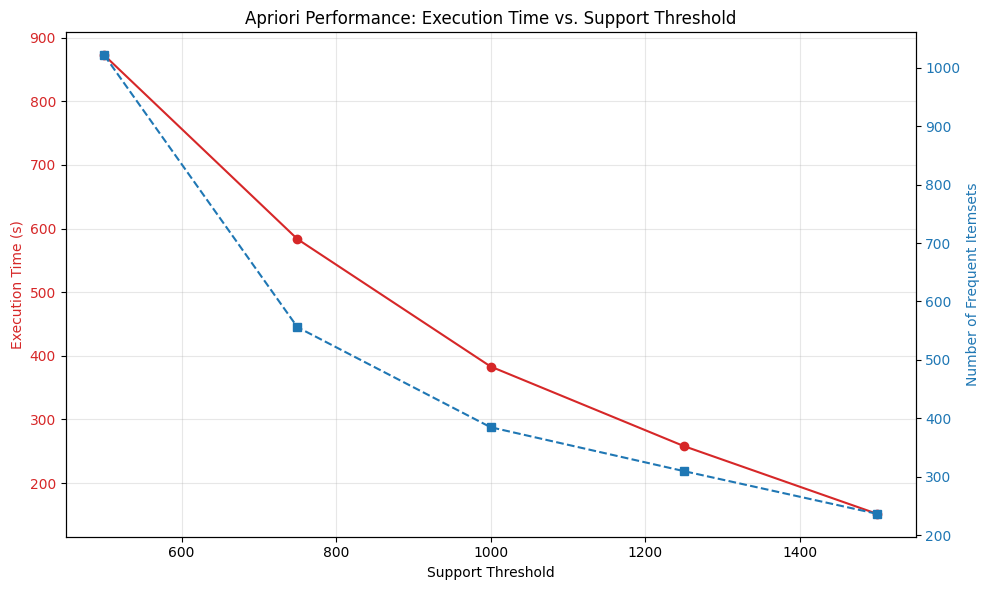

In [10]:
import matplotlib.pyplot as plt

# Visualization
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Support Threshold')
ax1.set_ylabel('Execution Time (s)', color=color)
ax1.plot(supports, durations, color=color, marker='o', label='Time')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Create a second y-axis to show the number of itemsets found
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Number of Frequent Itemsets', color=color)
ax2.plot(supports, n_freq_items, color=color, marker='s', linestyle='--', label='Itemsets Found')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Apriori Performance: Execution Time vs. Support Threshold')
fig.tight_layout()
plt.show()

When we look at the number of frequent itemsets, we observe that indeed the execution time depends on the number of itemsets to be found, which in turn depend on the support threshold.

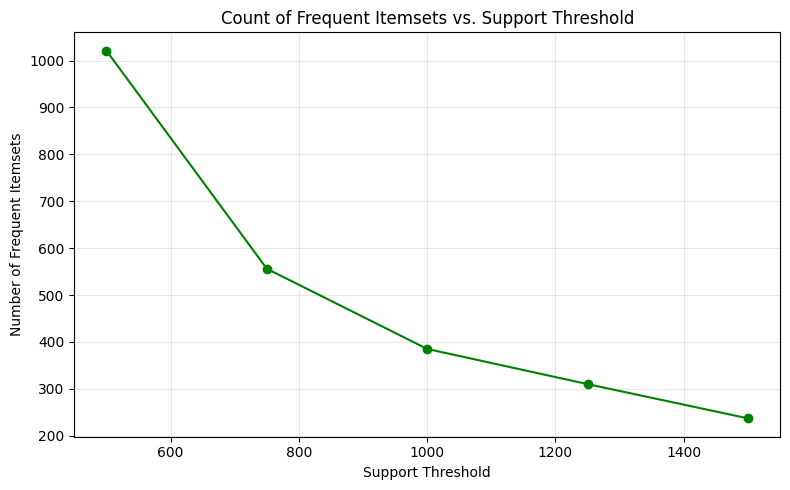

In [11]:
import matplotlib.pyplot as plt

# Visualization: Number of Frequent Itemsets vs. Support Threshold
plt.figure(figsize=(8, 5))

# We observe that the number of itemsets drops as the support threshold increases
plt.plot(supports, n_freq_items, marker='o', linestyle='-', color='green')

plt.xlabel('Support Threshold')
plt.ylabel('Number of Frequent Itemsets')
plt.title('Count of Frequent Itemsets vs. Support Threshold')
plt.grid(True, alpha=0.3) # Adds a light grid for easier reading

plt.tight_layout()
plt.show()

# Association rule mining (from Apriori frequent itemsets)

This section generates association rules A -> B where:
- support(A ∪ B) ≥ `min_support` (absolute count),
- confidence(A -> B) = support(A ∪ B) / support(A) ≥ `min_confidence`.

Rules are produced from the already-computed `freq_itemsets` dictionary:
`freq_itemsets[k]` is a dict mapping `tuple` (sorted itemset) → support count.

Output: a list of rules with support counts and fractions, confidence and lift; saved to `association_rules.csv`.

In [5]:
# Parameters for rule generation
min_support_rules = 1000           # absolute count threshold for support (s)
min_confidence = 0.6               # confidence threshold (c) as fraction between 0 and 1
top_n_rules_to_print = 30          # how many top rules to show on screen
output_rules_csv = "association_rules.csv"

try:
    n_transactions
except NameError:
    # fallback: compute from transactions if present
    try:
        n_transactions = len(transactions)
    except NameError:
        raise RuntimeError("n_transactions or transactions not found. Run the data-loading / Apriori cells first.")
print("n_transactions:", n_transactions)
print("min_support (abs):", min_support_rules, "min_confidence:", min_confidence)

n_transactions: 100000
min_support (abs): 1000 min_confidence: 0.6


## Function: generate association rules

This function:
- takes `freq_itemsets` (k → {tuple: support_count}),
- `min_support` (absolute) and `min_confidence` (fraction),
- returns a list of rules as dictionaries with keys:
  `antecedent` (tuple), `consequent` (tuple), `support_count`, `support_frac`, `confidence`, `lift`.
  
Notes:
- We require antecedent and consequent to be non-empty and disjoint, and antecedent ∪ consequent to be a frequent itemset.
- Lift is computed as: lift = confidence / support(consequent)_fraction = (sup(J)/sup(A)) / (sup(B)/N) = sup(J) * N / (sup(A) * sup(B))

In [6]:
from itertools import combinations
from collections import defaultdict
import csv

def generate_association_rules(freq_itemsets, n_transactions, min_support, min_confidence):
    """
    freq_itemsets: dict k -> {itemset_tuple: support_count}
    n_transactions: int
    min_support: absolute count threshold (s)
    min_confidence: fraction threshold (c)
    
    returns: list of rule dicts sorted by confidence then support
    """
    # Build support lookup: tuple(sorted(...)) -> count
    support = {}
    for k, d in freq_itemsets.items():
        for itemset, cnt in d.items():
            # store as tuple(sorted(...)) for consistency
            support[tuple(sorted(itemset))] = cnt

    rules = []
    # iterate over all frequent itemsets of size >= 2
    for k in sorted(freq_itemsets.keys()):
        if k < 2:
            continue
        for itemset_tuple, sup_J in freq_itemsets[k].items():
            items = tuple(sorted(itemset_tuple))
            # enumerate all non-empty proper antecedent subsets A
            n_items = len(items)
            # skip if sup_J < min_support (shouldn't happen, but safe)
            if sup_J < min_support:
                continue
            for r in range(1, n_items):
                for antecedent in combinations(items, r):
                    antecedent = tuple(sorted(antecedent))
                    consequent = tuple(sorted(set(items) - set(antecedent)))
                    # antecedent must have support (it should, by Apriori) — guard anyway
                    sup_A = support.get(antecedent, 0)
                    if sup_A == 0:
                        continue
                    confidence = sup_J / sup_A
                    if confidence + 1e-12 >= min_confidence:
                        # compute support fraction and lift
                        sup_B = support.get(consequent, 0)
                        support_frac = sup_J / n_transactions
                        # compute lift safely (avoid zero division)
                        if sup_B > 0:
                            lift = (sup_J * n_transactions) / (sup_A * sup_B)
                        else:
                            lift = None
                        # only include rule if sup_J >= min_support (already true)
                        rule = {
                            "antecedent": antecedent,
                            "consequent": consequent,
                            "support_count": sup_J,
                            "support_frac": support_frac,
                            "confidence": confidence,
                            "lift": lift,
                            "support_antecedent": sup_A,
                            "support_consequent": sup_B
                        }
                        rules.append(rule)
    # sort rules by confidence desc, then support_count desc
    rules_sorted = sorted(rules, key=lambda r: (-r["confidence"], -r["support_count"]))
    return rules_sorted

# convenience function to write CSV
def save_rules_to_csv(rules, path):
    with open(path, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["antecedent", "consequent", "support_count", "support_frac", "confidence", "lift",
                        "support_antecedent", "support_consequent"])
        for r in rules:
            writer.writerow([
                " ".join(map(str, r["antecedent"])),
                " ".join(map(str, r["consequent"])),
                r["support_count"],
                f"{r['support_frac']:.6f}",
                f"{r['confidence']:.6f}",
                f"{r['lift']:.6f}" if r["lift"] is not None else "",
                r["support_antecedent"],
                r["support_consequent"]
            ])

## Run rule generation and show top rules
This cell runs the generator with the `min_support_rules` and `min_confidence` from the parameters cell,
prints the number of rules and the top `top_n_rules_to_print` rules.
It also saves rules to `association_rules.csv`.

In [7]:
# generate rules (uses freq_itemsets from Apriori)
rules = generate_association_rules(freq_itemsets, n_transactions, min_support_rules, min_confidence)
print(f"Generated {len(rules)} rules (min_support={min_support_rules}, min_confidence={min_confidence})")

# print top rules
to_show = min(len(rules), top_n_rules_to_print)
if to_show == 0:
    print("No rules found with those thresholds.")
else:
    print(f"\nTop {to_show} rules (antecedent -> consequent) with support_count, support_frac, confidence, lift:")
    for i, r in enumerate(rules[:to_show], 1):
        ant = " ".join(map(str, r["antecedent"]))
        con = " ".join(map(str, r["consequent"]))
        print(f"{i:2d}. {ant} -> {con}    sup={r['support_count']} ({r['support_frac']:.4f})  "
            f"conf={r['confidence']:.3f}  lift={r['lift']:.3f}" if r['lift'] is not None else
            f"{i:2d}. {ant} -> {con}    sup={r['support_count']} ({r['support_frac']:.4f})  conf={r['confidence']:.3f}")

# save
save_rules_to_csv(rules, output_rules_csv)
print(f"\nSaved rules to {output_rules_csv}")

Generated 5 rules (min_support=1000, min_confidence=0.6)

Top 5 rules (antecedent -> consequent) with support_count, support_frac, confidence, lift:
 1. 704 825 -> 39    sup=1035 (0.0103)  conf=0.939  lift=22.057
 2. 39 704 -> 825    sup=1035 (0.0103)  conf=0.935  lift=30.307
 3. 39 825 -> 704    sup=1035 (0.0103)  conf=0.872  lift=48.603
 4. 704 -> 39    sup=1107 (0.0111)  conf=0.617  lift=14.492
 5. 704 -> 825    sup=1102 (0.0110)  conf=0.614  lift=19.912

Saved rules to association_rules.csv


We decide to vary the confidence threshold and analyze how it affects the execution time and the number of rules generated.

In [14]:
import time

# Define confidence thresholds
confidences = [0.1, 0.3, 0.5, 0.7, 0.9]
durations = []
n_rules_list = []

print(f"Benchmarking rule generation on {len(confidences)} thresholds...")

# 2. Loop through thresholds
for c in confidences:
    start = time.time()
    
    rules = generate_association_rules(
        freq_itemsets, 
        n_transactions, 
        min_support=min_support,  
        min_confidence=c
    )
    
    duration = time.time() - start
    durations.append(duration)
    n_rules_list.append(len(rules))
    
    print(f"Conf={c}: Found {len(rules)} rules in {duration:.4f}s")

Benchmarking rule generation on 5 thresholds...
Conf=0.1: Found 24 rules in 0.0006s
Conf=0.3: Found 13 rules in 0.0002s
Conf=0.5: Found 7 rules in 0.0002s
Conf=0.7: Found 3 rules in 0.0001s
Conf=0.9: Found 2 rules in 0.0001s


We observe that the execution time of this task is minimal and independent of the number of rules. There is a small variance in that is most likely because of the parallel execution of other tasks.

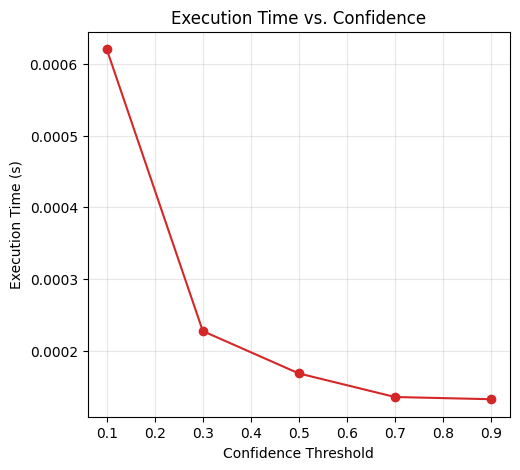

In [15]:
plt.figure(figsize=(12, 5))

# Plot 1: Execution Time vs Confidence
plt.subplot(1, 2, 1)
plt.plot(confidences, durations, marker='o', color='tab:red')
plt.xlabel('Confidence Threshold')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs. Confidence')
plt.grid(True, alpha=0.3)

Finally, when we look at the number of rules generated, as expected, they decrease with the increase of the confidence threshold as less associations are as strong as required.

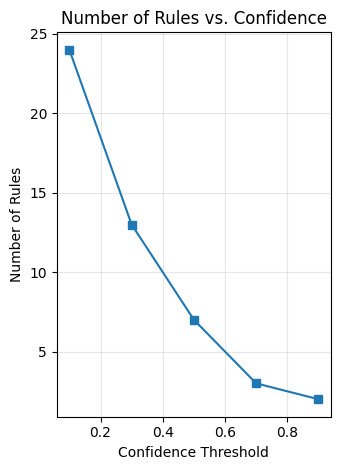

In [16]:
# Plot 2: Number of Rules vs Confidence
plt.subplot(1, 2, 2)
plt.plot(confidences, n_rules_list, marker='s', color='tab:blue')
plt.xlabel('Confidence Threshold')
plt.ylabel('Number of Rules')
plt.title('Number of Rules vs. Confidence')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()